In [1]:
# basic torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

# hyperparameter optimization rtd
import optuna
import wandb

# os related
import os

# file handling

# segmentation model
from lora_vit import LoraVit
from segmentation_model import SegViT
from segmentation_head import CustomSegHead

# dataset class
from pet_dataset_class import PreprocessedPetDataset

# dataloaders
from create_dataloaders import get_pet_dataloaders

# trainer
from trainer import trainer

# loss and metrics
from loss_and_metrics_seg import * # idk what to import here tbh. Need to look into it

# data plotting
from data_plotting import plot_random_images_and_trimaps_2


In [2]:
# modules for loading the vit model
from transformers import ViTModel, ViTImageProcessor

In [3]:
## load the pre-trained ViT-model (86 Mil)
model_name = 'google/vit-base-patch16-224'

image_processor = ViTImageProcessor.from_pretrained(model_name)
VIT_PRETRAINED = ViTModel.from_pretrained(model_name)
vit_pretrained_2 = ViTModel.from_pretrained(model_name)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# CHECKING SOMETHING
# {'lora_rank': 4, 'lora_alpha': 4, 'lora_layers': [6, 7, 8, 9, 10, 11], 'lr': 0.0003111593560386509, 'weight_decay': 0.0006003342110635857, 'optimizer': 'adam', 'batch_size': 32, 'dropout_prob': 0.15, 'use_bn': False} 
# lora_vit_base_check= LoraVit(vit_model=VIT_PRETRAINED,
#                             r=4, alpha=4, lora_layers=[6,7,8,9,10,11])

In [5]:
# instantiating the lora vit based backbone model
lora_vit_base = LoraVit(vit_model=VIT_PRETRAINED,
                        r=4,alpha = 16, lora_layers = [1,2,3,4])

# lora_vit_base2 = LoraVit(vit_model=vit_pretrained_2,
#                         r=4,alpha = 16, lora_layers = [1])

In [6]:
# number of trainable parameters
lora_vit_base.num_trainable_params#, lora_vit_base2.num_trainable_params 

49152

In [7]:
check_seg_head_model = CustomSegHead(hidden_dim=768, num_classes=3, patch_size=16, image_size=224) 
check_seg_head_model.num_trainable_params 

2655747

In [8]:
# instantiate the segmentation model
vit_seg_model = SegViT(vit_model=lora_vit_base,image_size=224, patch_size=16
                    , dim= 768,
                    n_classes=3) # I am still not sure about n_classes thingy yet. need to look into that.

In [9]:
vit_seg_model.num_trainable_params # checked: number of param = lora_vit backbone + segmentation head

2704899

In [10]:
# get path of image and mask files
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g. in Jupyter notebook or interactive sessions apparently), fallback to cwd
    base_dir = os.getcwd()

# Suppose your dataset is in a folder named 'data' inside the project root:
data_dir = os.path.join(base_dir, 'data_oxford_iiit')

# # Then you can define image and trimap paths relative to that
image_folder = os.path.join(data_dir, 'resized_images')
trimap_folder = os.path.join(data_dir, 'resized_masks')

In [14]:
# create dataloaders
train_dl, val_dl, test_dl = get_pet_dataloaders(
    image_folder=image_folder,
    mask_folder=trimap_folder,
    DatasetClass=PreprocessedPetDataset,
    all_data=False,
    num_datapoints=30, # right now I am just testing whether the things would work or not. I will intentionally overtrain it.
    batch_size=24
) 

[INFO] Using only 30 datapoints out of 7390 total files.
train_size: 24, val_size: 3 and test_size: 3


In [15]:
# define the input parameters for the trainer
trainer_input_params = {
    "model": vit_seg_model , 
    "optimizer": torch.optim.Adam(vit_seg_model.parameters(), lr=1e-4),
    #"lr": 1e-4,
    "criterion": log_cosh_dice_loss,  # or log_cosh_dice_loss, whichever you want to use
    "num_epoch": 3,
    "dataloaders": {
        "train": train_dl,  # replace with your actual DataLoader
        "val": val_dl       # replace with your actual DataLoader
    },
    "use_trap_scheduler": False,             # or your scheduler instance if you use one
    "device": "cpu",#"cuda" if torch.cuda.is_available() else "cpu",
    #"model_kwargs": {},            # add any extra forward() kwargs if needed
    "criterion_kwargs": {
        "num_classes": 3,
        "epsilon": 1e-6,
        # "return_metrics": False    # usually False for training, True for validation if you want metrics ## WE DO NOT NEED THIS HERE
    }
}


In [16]:
# instantiate the trainer
trainer_seg_model = trainer(**trainer_input_params) 

In [17]:
trainer_seg_model.train() # need to look into this thing

Epochs:  33%|███▎      | 1/3 [01:22<02:45, 82.91s/it]

Epoch [1/3] - Train Loss: 0.2235 | Val Loss: 0.1980 | Dice score: 0.3496720790863037 |IOU score: 0.2204217 


Epochs:  67%|██████▋   | 2/3 [03:03<01:33, 93.05s/it]

Epoch [2/3] - Train Loss: 0.1880 | Val Loss: 0.1723 | Dice score: 0.39602991938591003 |IOU score: 0.2625288 


Epochs: 100%|██████████| 3/3 [04:36<00:00, 92.18s/it]

Epoch [3/3] - Train Loss: 0.1602 | Val Loss: 0.1517 | Dice score: 0.4350813627243042 |IOU score: 0.3013934 


In [31]:
# let us send a training input and get an output and see what it looks like. if it returns something like a segmentation mask, it implies that our training is indeed working
trainer_seg_model.model.eval()
with torch.no_grad():
    for minibatch_input, truth in trainer_seg_model.dataloaders["train"]:
        minibatch_input, truth = minibatch_input.to("cpu"), truth.to("cpu")
        output_val_minibatch = trainer_seg_model.model(minibatch_input)
        break 

In [22]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def plot_segmentation_batch(images, masks, preds, num_samples=5):
    """
    Plots N samples of input image, ground truth, and prediction side-by-side.

    Args:
        images: Tensor of shape (N, 3, H, W)
        masks: Tensor of shape (N, H, W)
        preds: Tensor of shape (N, C, H, W) — raw logits or softmax probs
        num_samples: Number of samples to visualize (default = 5)
    """
    num_samples = min(num_samples, images.shape[0])
    preds_classes = torch.argmax(preds, dim=1)  # (N, H, W)

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    if num_samples == 1:
        axs = axs.unsqueeze(0)  # handle single-row case

    for i in range(num_samples):
        image_np = TF.to_pil_image(images[i].cpu())
        gt_mask = masks[i].cpu()
        pred_mask = preds_classes[i].cpu()

        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(gt_mask, cmap='jet')
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred_mask, cmap='jet')
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()




In [23]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(img_tensor, mean, std):
    """
    Denormalize an image tensor using mean and std.
    Args:
        img_tensor: Tensor of shape (3, H, W)
        mean: List of means per channel (R, G, B)
        std: List of stds per channel (R, G, B)
    Returns:
        Denormalized tensor clipped to [0, 1]
    """
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img_tensor, 0, 1)

def plot_segmentation_batch(images, masks, preds, num_samples=5, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Plots N samples of input image, ground truth, and prediction side-by-side.
    
    Args:
        images: Tensor of shape (N, 3, H, W)
        masks: Tensor of shape (N, H, W)
        preds: Tensor of shape (N, C, H, W) — raw logits or softmax probs
        num_samples: Number of samples to visualize
        mean: Mean used for normalization (for denormalization)
        std: Std used for normalization (for denormalization)
    """
    num_samples = min(num_samples, images.shape[0])
    preds_classes = torch.argmax(preds, dim=1)  # (N, H, W)

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    if num_samples == 1:
        axs = axs.unsqueeze(0)

    for i in range(num_samples):
        img = denormalize(images[i].cpu().clone(), mean, std)
        img_np = TF.to_pil_image(img)

        gt_mask = masks[i].cpu()
        pred_mask = preds_classes[i].cpu()

        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(gt_mask, cmap='jet')
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred_mask, cmap='jet')
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


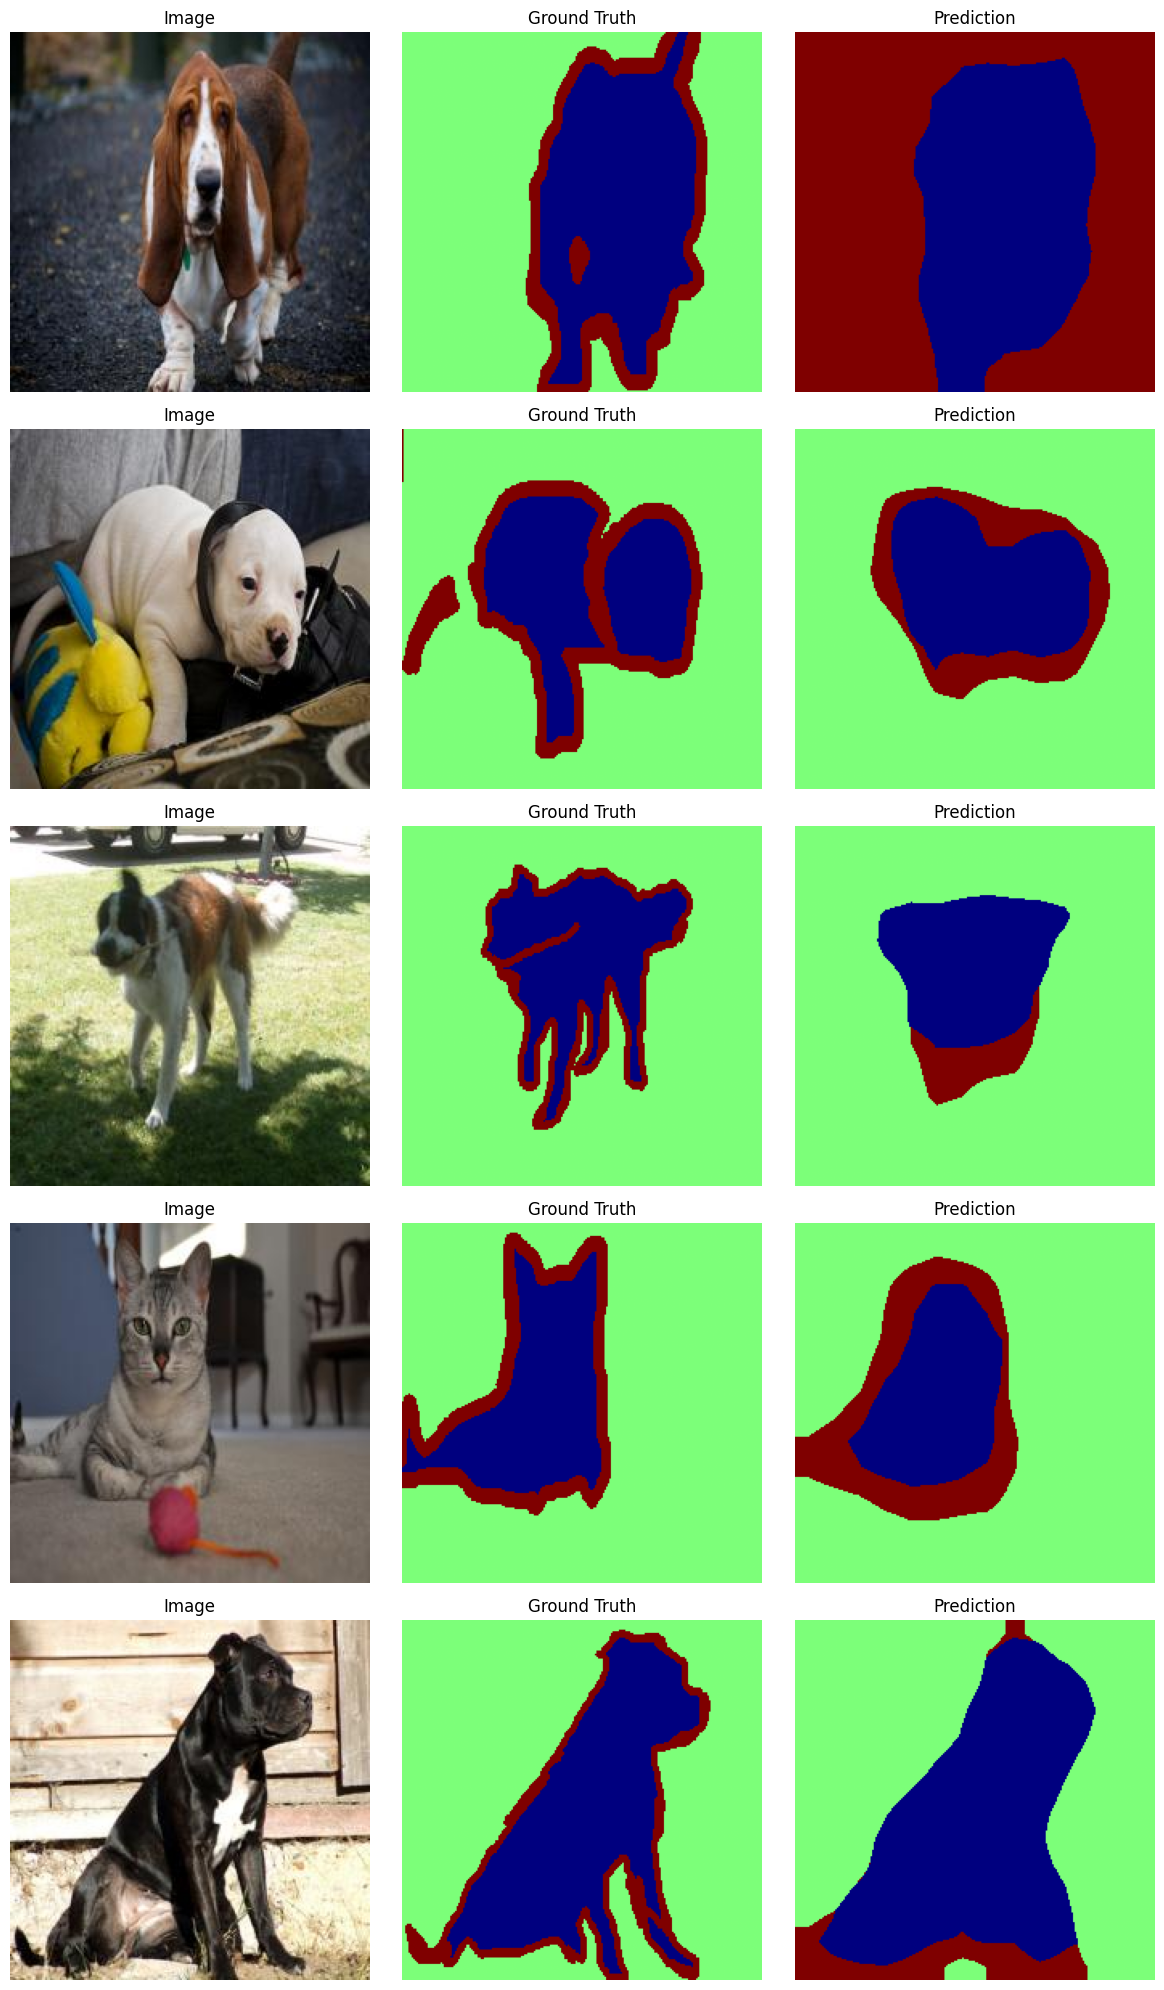

In [34]:
plot_segmentation_batch(minibatch_input, truth, output_val_minibatch, num_samples=5)

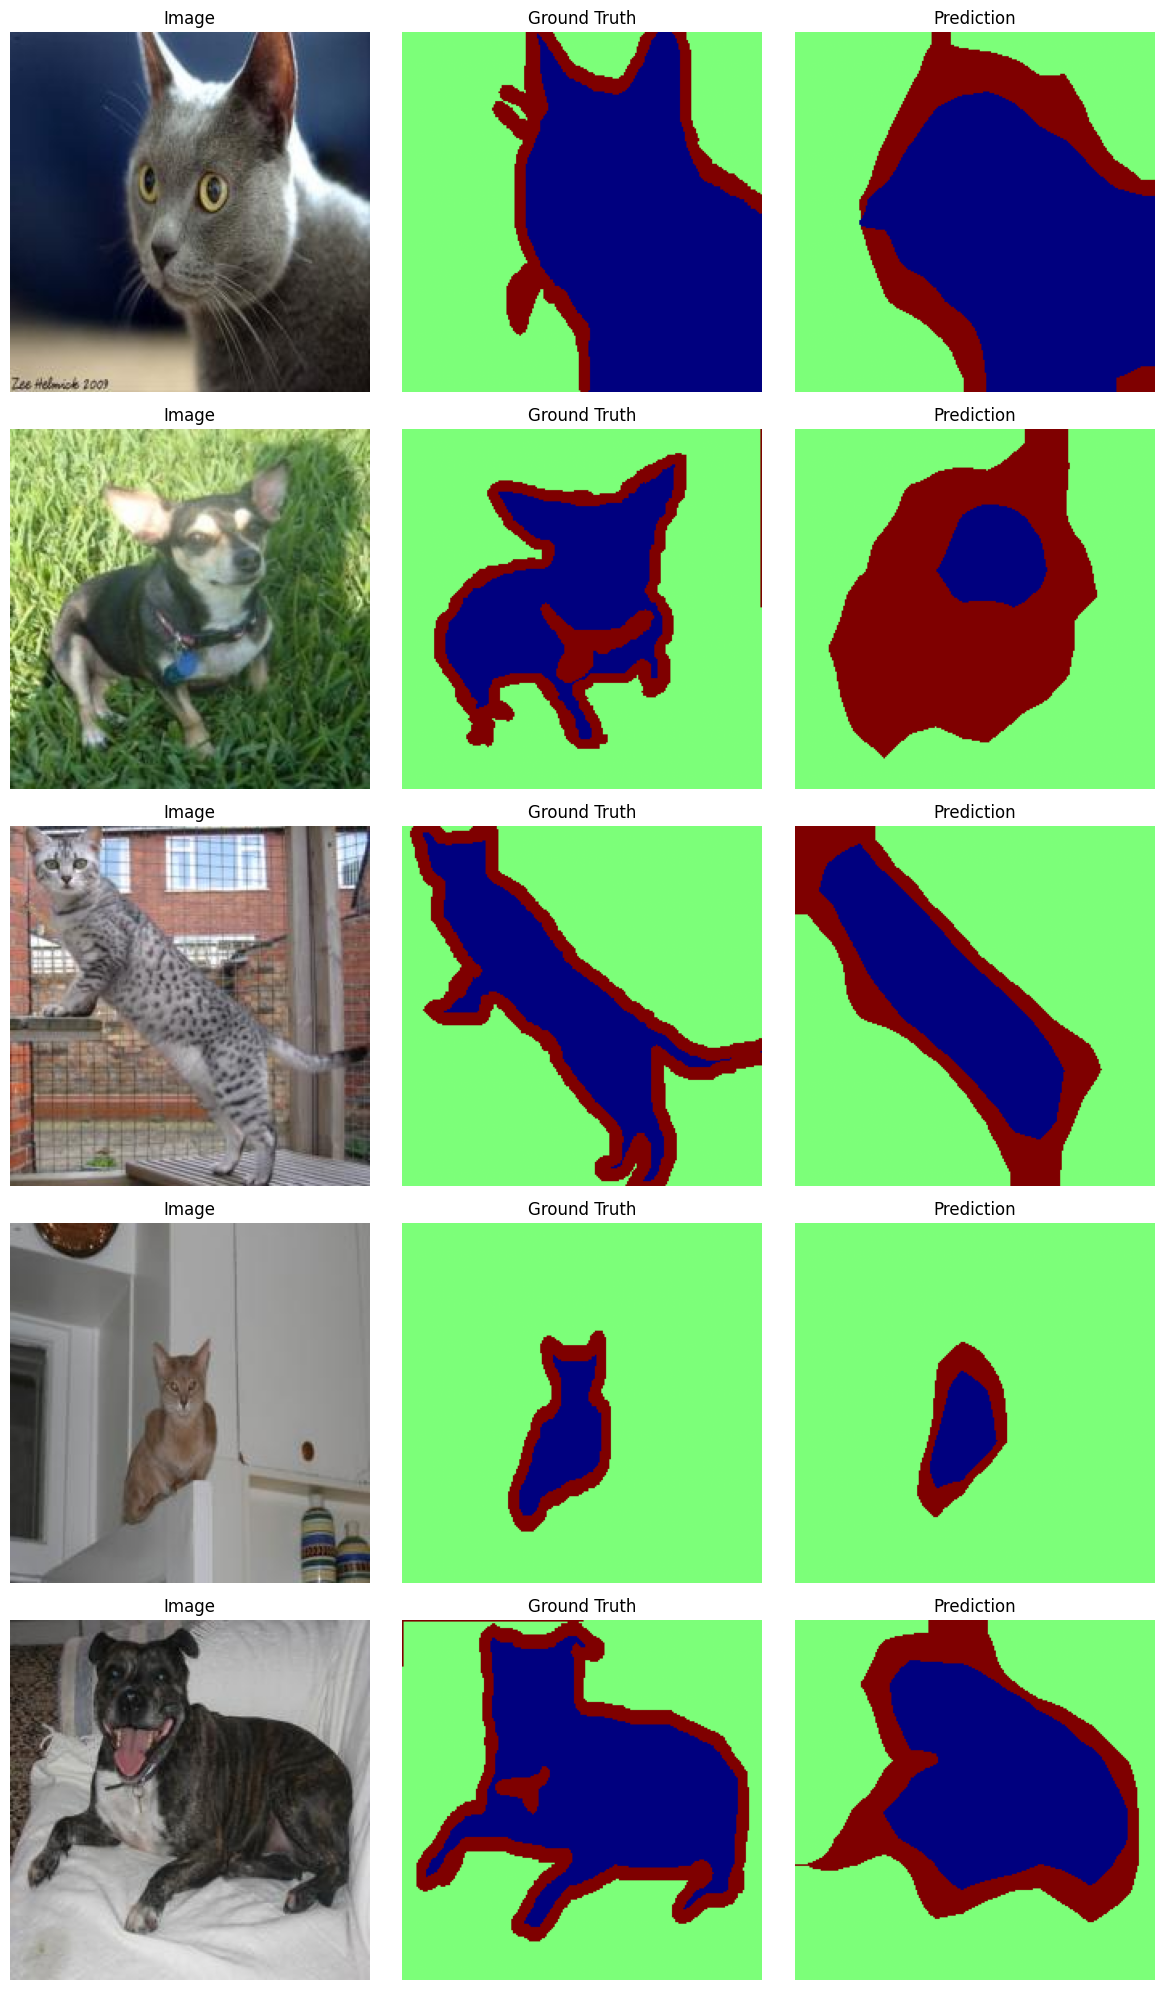

In [38]:
plot_segmentation_batch(minibatch_input, truth, output_val_minibatch, num_samples=5)

Tasks for Neel:

1. Look into the potential hyperparameters and then create a wandb script to carry out hyperparameter optimization.
    * ~~Add regularisation provision in the custom head.~~
    * ~~Once again look into the objective functions for training and then evaluation metric using the test dataset (because the loss function won't be used for characterising the quality of the training). Maybe we can also use them for training.~~
    * I need to set up code for optuna based hyperparameter search.
        * ~~Wrote the intial code, Need to finalise it~~
        * Finalised the optuna based hyperparam search code. 
            * ALMOST DONE. Need to run it with very small number of training examples to see if it is indeed running or not.
2. Plan out the potential ablation study.
3. Look into other LoRA variants of fine-tuning.

Code for hyperparameter optimization

In [ ]:
# possible search space:
# search_space = {
#     "lora_rank": [4, 8, 16, 32],
#     "lora_alpha": [4, 8, 16, 32, 64],# maybe tied to rank
#     "lora_layers": ["all", "last_half", "last_3"],# this I need to look into more deeply

#     "lr_backbone": (1e-5, 5e-5), # log scale
#     "lr_head": (1e-4, 1e-3), # log scale
#     "weight_decay": (1e-4, 1e-2),

#     "optimizer": ["adamw", "adam"],# seperate optimizers for backbone and head?

#     "loss_fn": ["cross_entropy", "dice", "focal", "ce+dice"],# need to look  into it later.

#     "batch_size": [8, 16, 32]
# }


In [4]:
wandb.login(key="b47c50d9d7a54018ff9133f43a7d0d5ce08cdb1e")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\NEELKANTH RAWAT\.netrc
wandb: Currently logged in as: neelkanth-rawat (network-to-network) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# get path of image and mask files
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g. in Jupyter notebook or interactive sessions apparently), fallback to cwd
    base_dir = os.getcwd()

# Suppose your dataset is in a folder named 'data' inside the project root:
data_dir = os.path.join(base_dir, 'data_oxford_iiit')

# # Then you can define image and trimap paths relative to that
image_folder = os.path.join(data_dir, 'resized_images')
trimap_folder = os.path.join(data_dir, 'resized_masks')

In [ ]:
NUM_BLOCKS = 12 # len(vit_pretrained.encoder.layer)
# Deterministic LoRA layer options
LORA_LAYER_OPTIONS = [
    tuple(range(3)),                       # first 3 layers
    tuple(range(NUM_BLOCKS-3, NUM_BLOCKS)),# last 3 layers
    tuple(range(6)),                       # first 6 layers
    tuple(range(NUM_BLOCKS-6, NUM_BLOCKS)) # last 6 layers
]

def objective(trial, optimize_for="loss"):
    # Sample hyperparameters
    lora_rank = trial.suggest_categorical("lora_rank", [4, 8, 16])
    lora_alpha = trial.suggest_categorical("lora_alpha", [4, 8, 16, 32])
    
    lora_layers = trial.suggest_categorical("lora_layers", LORA_LAYER_OPTIONS)
    
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True)# L2 decay
    optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adam"]) 
    
    batch_size = trial.suggest_categorical("batch_size", [8, 16,24])#, 24, 32])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.15])
    use_bn = trial.suggest_categorical("use_bn", [True, False])

    # W&B setup
    wandb.init(
        project="Lora_vit_segmentation",
        config={
            "lora_rank": lora_rank,
            "lora_alpha": lora_alpha,
            "lora_layers": lora_layers,
            "lr": lr,
            "weight_decay": weight_decay,
            "optimizer": optimizer_name,
            "batch_size": batch_size,
            "dropout_rate": dropout_rate,
            "use_bn": use_bn,
            "num_epochs": 5
        },
        reinit='finish_previous' # This ensures that a new W&B run is created for each Optuna trial.
    )

    # Create model with current trial's hyperparameters
    image_processor = ViTImageProcessor.from_pretrained(model_name)
    Vit_pretrained = ViTModel.from_pretrained(model_name)
    lora_vit_base = LoraVit(vit_model=Vit_pretrained,# this vit_pretrained is defined globally (in cell number 3)
                            r=lora_rank, alpha=lora_alpha,
                            lora_layers=lora_layers)
    
    seg_head = CustomSegHead(hidden_dim=768, num_classes=3,                 patch_size=16,image_size=224,
                            dropout_rate=dropout_rate, use_bn=use_bn)
    
    vit_seg_model = SegViT(vit_model=lora_vit_base,
                        image_size=224, patch_size=16,
                        dim=768, n_classes=3,
                        head=seg_head)

    # Create dataloaders with sampled batch size 
    train_dl, val_dl, _ = get_pet_dataloaders(
        image_folder=image_folder,
        mask_folder=trimap_folder,
        DatasetClass=PreprocessedPetDataset,
        all_data=False,
        num_datapoints=25,
        val_ratio=0.2,
        test_ratio=0.1,
        batch_size=batch_size
    )

    # Setup optimizer
    optimizer_cls = torch.optim.AdamW if optimizer_name == "adamw" else torch.optim.Adam
    optimizer = optimizer_cls(vit_seg_model.parameters(), lr=lr, weight_decay=weight_decay)

    # Trainer
    trainer_input_params = {
        "model": vit_seg_model,
        "optimizer": optimizer,
        "lr": lr,
        "criterion": log_cosh_dice_loss,
        "num_epoch": 5,
        "dataloaders": {"train": train_dl, "val": val_dl},
        "use_trap_scheduler":True,
        "device": "cpu",
        "criterion_kwargs": {"num_classes": 3, "epsilon": 1e-6}
    }

    trainer_seg_model = trainer(**trainer_input_params)
    # trainer_seg_model.train() # I had to comment it because for W&B, to log and plot curves in real time, I need to create loopwise functions here
    
    # Training loop with W&B logging
    for epoch in range(trainer_seg_model.num_epoch):
        #  train and validation step for each epoch
        avg_train_loss = trainer_seg_model.train_epoch(epoch)
        avg_val_loss, avg_val_dice, avg_val_iou = trainer_seg_model.val_epoch()# unpack all three values returned by val_epoch

        # accumulate losses
        trainer_seg_model.train_error_epoch_list.append(avg_train_loss)
        trainer_seg_model.val_error_epoch_list.append(avg_val_loss)
        # accumulate metrics
        trainer_seg_model.val_dice_epoch_list.append(avg_val_dice)
        trainer_seg_model.val_iou_epoch_list.append(avg_val_iou)

        # log to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_dice": avg_val_dice,
            "val_iou": avg_val_iou,
            "lr": optimizer.param_groups[0]["lr"]
        })


    # after we train(), in the class trainer_seg_model, validation loss and validation metrics are stored for each epoch as class attributes
    if optimize_for == "loss":
        result = trainer_seg_model.val_error_epoch_list[-1]
    elif optimize_for == "dice":
        result = trainer_seg_model.val_dice_epoch_list[-1]
    elif optimize_for == "iou":
        result = trainer_seg_model.val_iou_epoch_list[-1]
    else:
        raise ValueError(f"Unknown optimize_for='{optimize_for}'")

    # finish W&B run
    wandb.finish() 

    return result

In [ ]:
# Optimize for loss
N_TRIALS=5
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, optimize_for="loss"), n_trials=N_TRIALS)
# Print best hyperparameters
print(study.best_params)

In [ ]:
# Optimize for dice
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, optimize_for="dice"), n_trials=N_TRIALS)
# Print best hyperparameters
print(study.best_params)


In [ ]:
# Optimize for IoU
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, optimize_for="iou"), 
            n_trials=N_TRIALS)
# Print best hyperparameters
print(study.best_params)

### Discussion

1. ~~check implementation of the IOU once again.~~ # seems correct to me.
2. custom head. 
    * baseline: Training of just head. [1]
    * ~~different learning rate for the segmentation head and viT backbone.~~ [3]
    * ~~when you start training, for the first few steps, freeze the backbone so that the head has chance to adjust to the backbone.~~ [2]
        * ~~once it stabilises, then unfreeze and then use~~ 
            1. ~~single learning rate and [2.1]~~
            2. ~~seperate learning rate. [3.1]~~
3. Is there some consistent point where these approaches fail.
4. ~~Implement serial LoRA [4] (I have begun already)~~
5. Maybe I should also look into one more advanced loRA approach to see or design some ablation experiments. # maybe look into that med-adapter appraoch and see what are the results you get from it.

Checking the implementation of IOU first

In [ ]:
# I need to check a few things: training of just the head and then try to see how e